In [1]:
# !nvidia-smi

In [2]:
# !sudo apt update
# !sudo apt install gcc-11 g++-11
# # GCC에 대한 대안 추가
# !sudo update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-11 10
# !sudo update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-11 10

# # 대안 선택
# !sudo update-alternatives --config gcc
# !sudo update-alternatives --config g++
    
# !pip install pycuda

In [3]:
# !gcc --version

In [4]:
# !ls

In [5]:
#pip install scikit-learn

In [6]:
#pip install dask
#pip install yellowbrick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import platform
from sklearn.preprocessing import StandardScaler

# import pycuda.autoinit
# import pycuda.driver as cuda
# from pycuda.compiler import SourceModule
# import pycuda.gpuarray as gpuarray
import numpy as np
from time import time

/home/hijinn/miniconda3/envs/st/lib/python3.13/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# 데이터셋 호출
df = pd.read_csv('./edu_data_F.csv')
df.head()

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,GROCERY_AM,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM
0,2023q3,WDJXI9MJ1X41AITHZ3IU,25,2,25,202305,경기,Y,Y,NaN,...,20,0,10,50,0,0,0,0,0,0
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,0
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,NaN,...,0,100,0,10,0,0,0,0,0,0
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,NaN,...,10,100,0,10,0,0,0,10,0,0
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,NaN,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#'HOUS_SIDO_NM'변수의 결측치 제거
df['HOUS_SIDO_NM'].isna().sum()/len(df) #결측치 비율 : 9.288959848285277e-06
df[df['HOUS_SIDO_NM'].isna() == True].head() # nan인 특정 이유 없어 보임
# 행 삭제
df = df.dropna(subset=['HOUS_SIDO_NM']).reset_index(drop=True)

In [9]:
## LIFE_STAGE 결측치 채우기 최적화 version
# BAS_YH에서 연도 추출
df['Year'] = df['BAS_YH'].str[:4].astype(int)

# 연도별 및 SEQ별로 최빈값 계산 (기타 제외)
life_mode = df.groupby(['SEQ', 'Year'])['LIFE_STAGE'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
life_mode.columns = ['SEQ', 'Year', 'Mode_LIFE']

# 원본 데이터와 age_mode를 병합하여 'LIFESTAGE'가 NAN인 경우에만 'Mode_LIFE' 값을 채우기
df = df.merge(life_mode, on=['SEQ', 'Year'], how='left')
df['LIFE_STAGE'] = df['LIFE_STAGE'].fillna(df['Mode_LIFE'])

# Mode_LIFE_STAGE 컬럼 삭제
df.drop(columns='Mode_LIFE', inplace=True)

# 결과 확인
df

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM,Year
0,2023q3,WDJXI9MJ1X41AITHZ3IU,25,2,25,202305,경기,Y,Y,None,...,0,10,50,0,0,0,0,0,0,2023
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,None,...,100,0,10,0,0,0,0,0,0,2023
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,None,...,100,0,10,0,0,0,10,0,0,2023
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,None,...,0,0,0,0,0,0,0,0,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,2022q4,H7OGM4TJT2HEFD2ISYR3,60,2,25,201911,경기,N,N,SECLIFE,...,40,0,10,0,0,0,0,0,0,2022
5382680,2023q3,GWNCCW05QJ73BE3G93PI,45,2,25,201604,부산,Y,N,None,...,0,0,0,0,0,0,0,0,0,2023
5382681,2022q3,YGEA6KKEQU7NPVY7DBKO,70,2,24,200611,경기,Y,Y,CHILD_UNI,...,30,20,30,0,0,0,0,0,0,2022
5382682,2022q4,ODC0228LVERCLGDL0990,45,1,25,202004,경북,N,N,CHILD_TEEN,...,10,0,50,0,0,0,0,0,0,2022


In [10]:
#LIFE_STAGE가 NaN인 고유 아이디 797331
len(df[df['LIFE_STAGE'].isnull()]['SEQ'].unique())

797331

In [11]:
# 연도별 및 SEQ별로 최빈값 계산
seq_life_mode = df[df['LIFE_STAGE'].notna()].groupby('SEQ')['LIFE_STAGE'].agg(lambda x: x.mode()[0]).reset_index()
seq_life_mode.columns = ['SEQ', 'Mode_LIFE']

# 원본 데이터와 life_mode를 병합하여 'LIFE_STAGE'가 '기타'인 경우에만 'Mode_LIFE' 값을 채우기
df = df.merge(seq_life_mode, on='SEQ', how='left')
df['LIFE_STAGE'] = df['LIFE_STAGE'].fillna(df['Mode_LIFE'])

# Mode_LIFE 컬럼 삭제
df.drop(columns='Mode_LIFE', inplace=True)

# 결과 확인
df

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM,Year
0,2023q3,WDJXI9MJ1X41AITHZ3IU,25,2,25,202305,경기,Y,Y,NaN,...,0,10,50,0,0,0,0,0,0,2023
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,0,0,0,2023
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,10,0,0,2023
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,2022q4,H7OGM4TJT2HEFD2ISYR3,60,2,25,201911,경기,N,N,SECLIFE,...,40,0,10,0,0,0,0,0,0,2022
5382680,2023q3,GWNCCW05QJ73BE3G93PI,45,2,25,201604,부산,Y,N,CHILD_TEEN,...,0,0,0,0,0,0,0,0,0,2023
5382681,2022q3,YGEA6KKEQU7NPVY7DBKO,70,2,24,200611,경기,Y,Y,CHILD_UNI,...,30,20,30,0,0,0,0,0,0,2022
5382682,2022q4,ODC0228LVERCLGDL0990,45,1,25,202004,경북,N,N,CHILD_TEEN,...,10,0,50,0,0,0,0,0,0,2022


In [12]:
#LIFE_STAGE가 NaN인 고유 아이디 84893
len(df[df['LIFE_STAGE'].isnull()]['SEQ'].unique())

84893

In [13]:
## AGE == 기타인 고유값  24608
##결측치 0개
len(df[df['AGE']=='기타']['SEQ'].unique())
df['AGE'].isnull().sum()

np.int64(0)

In [14]:
## AGE 결측치 채우기
##for문으로 너무 오래 걸림

# # BAS_YH에서 연도 추출
# df['Year'] = df['BAS_YH'].str[:4].astype(int)

# # AGE'가 '기타'인 경우, 연도별로 채워진 값을 설정
# def fill_age(row, age_2022, age_2023):
#     if row['AGE'] == '기타':
#         if row['Year'] == 2022:
#             return age_2022
#         elif row['Year'] == 2023:
#             return age_2023
#     return row['AGE']

# # 'AGE'가 '기타'인 'SEQ'별로 연도별 최빈값 적용
# for i in df[df['AGE'] == '기타']['SEQ'].unique():
#     # SEQ별로 2022년과 2023년의 최빈값을 찾음
#     age_2022 = df[(df['Year'] == 2022) & (df['SEQ'] == i) & (df['AGE'] != '기타')]['AGE'].mode().iloc[0]
#     age_2023 = df[(df['Year'] == 2023) & (df['SEQ'] == i) & (df['AGE'] != '기타')]['AGE'].mode().iloc[0]
    
#     # SEQ가 특정 값인 경우에만 적용하여 'AGE' 값 채우기
#     df.loc[df['SEQ'] == i, 'AGE'] = df[df['SEQ'] == i].apply(lambda row: fill_age(row, age_2022, age_2023), axis=1)

# # 결과 확인
# print(df)

In [15]:
## AGE 결측치 채우기 최적화 version
# BAS_YH에서 연도 추출
df['Year'] = df['BAS_YH'].str[:4].astype(int)

# 연도별 및 SEQ별로 최빈값 계산 (기타 제외)
age_mode = df[df['AGE'] != '기타'].groupby(['SEQ', 'Year'])['AGE'].agg(lambda x: x.mode()[0]).reset_index()
age_mode.columns = ['SEQ', 'Year', 'Mode_AGE']

# 원본 데이터와 age_mode를 병합하여 'AGE'가 '기타'인 경우에만 'Mode_AGE' 값을 채우기
df = df.merge(age_mode, on=['SEQ', 'Year'], how='left')
df['AGE'] = df['AGE'].where(df['AGE'] != '기타', df['Mode_AGE'])

# Mode_AGE 컬럼 삭제
df.drop(columns='Mode_AGE', inplace=True)

# 결과 확인
df

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM,Year
0,2023q3,WDJXI9MJ1X41AITHZ3IU,25,2,25,202305,경기,Y,Y,NaN,...,0,10,50,0,0,0,0,0,0,2023
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,0,0,0,2023
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,10,0,0,2023
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,2022q4,H7OGM4TJT2HEFD2ISYR3,60,2,25,201911,경기,N,N,SECLIFE,...,40,0,10,0,0,0,0,0,0,2022
5382680,2023q3,GWNCCW05QJ73BE3G93PI,45,2,25,201604,부산,Y,N,CHILD_TEEN,...,0,0,0,0,0,0,0,0,0,2023
5382681,2022q3,YGEA6KKEQU7NPVY7DBKO,70,2,24,200611,경기,Y,Y,CHILD_UNI,...,30,20,30,0,0,0,0,0,0,2022
5382682,2022q4,ODC0228LVERCLGDL0990,45,1,25,202004,경북,N,N,CHILD_TEEN,...,10,0,50,0,0,0,0,0,0,2022


In [16]:
#LIFE_STAGE가 NaN인 고유 아이디 20942
len(df[df['AGE'].isna()]['SEQ'].unique())

20942

In [17]:
# 연도별 및 SEQ별로 최빈값 계산
seq_age_mode = df[df['AGE'].notna()].groupby('SEQ')['AGE'].agg(lambda x: x.mode()[0]).reset_index()
seq_age_mode.columns = ['SEQ', 'Mode_AGE']

# 원본 데이터와 age_mode를 병합하여 'AGE'가 '기타'인 경우에만 'Mode_AGE' 값을 채우기
df = df.merge(seq_age_mode, on='SEQ', how='left')
df['AGE'] = df['AGE'].fillna(df['Mode_AGE'])

# Mode_AGE 컬럼 삭제
df.drop(columns='Mode_AGE', inplace=True)

# 결과 확인
df

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM,Year
0,2023q3,WDJXI9MJ1X41AITHZ3IU,25,2,25,202305,경기,Y,Y,NaN,...,0,10,50,0,0,0,0,0,0,2023
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,0,0,0,2023
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,10,0,0,2023
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,2022q4,H7OGM4TJT2HEFD2ISYR3,60,2,25,201911,경기,N,N,SECLIFE,...,40,0,10,0,0,0,0,0,0,2022
5382680,2023q3,GWNCCW05QJ73BE3G93PI,45,2,25,201604,부산,Y,N,CHILD_TEEN,...,0,0,0,0,0,0,0,0,0,2023
5382681,2022q3,YGEA6KKEQU7NPVY7DBKO,70,2,24,200611,경기,Y,Y,CHILD_UNI,...,30,20,30,0,0,0,0,0,0,2022
5382682,2022q4,ODC0228LVERCLGDL0990,45,1,25,202004,경북,N,N,CHILD_TEEN,...,10,0,50,0,0,0,0,0,0,2022


In [18]:
#LIFE_STAGE가 기타인 고유 아이디 16250
len(df[df['AGE'].isna()]['SEQ'].unique())

16250

In [19]:
#age 20인 unique id 50120명, 데이터 수 153288, 비율 2.85%
df['Year'] = df['BAS_YH'].str[:4].astype(int)
df[(df['Year'] == 2023) & (df['AGE'] == '20')]['SEQ'].nunique()
len(df[(df['Year'] == 2023) & (df['AGE'] == '20')])/len(df)

0.028477986075348283

In [20]:
# age가 20이거나 age가 isnull인 비율 4.20
len(df[((df['Year'] == 2023) & (df['AGE'] == '20')) | (df['AGE'].isna())])/len(df)

0.04202680298527649

In [21]:
df = df[~((df['Year'] == 2023) & (df['AGE'] == '20'))]

In [22]:
#LIFE_STAGE가 NaN인 고유 아이디 84893 -> 78255 데이터내 갯수는 164976 비율은 3.15
len(df[df['LIFE_STAGE'].isnull()]['SEQ'].unique())

78255

In [23]:
##LIFE_STAGE와 AGE가 NaN인 비율 4.40
len(df[(df['LIFE_STAGE'].isnull()) | (df['AGE'].isnull())])/len(df)

0.04401712932047984

In [24]:
df = df[~((df['LIFE_STAGE'].isnull()) | (df['AGE'].isnull()))]
df

,BAS_YH,SEQ,AGE,SEX_CD,MBR_RK,ATT_YM,HOUS_SIDO_NM,DIGT_CHNL_REG_YN,DIGT_CHNL_USE_YN,LIFE_STAGE,...,HOS_AM,CLOTH_AM,RESTRNT_AM,AUTOMNT_AM,AUTOSL_AM,KITWR_AM,FABRIC_AM,ACDM_AM,MBRSHOP_AM,Year
1,2022q3,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
2,2023q4,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,0,0,0,2023
3,2023q3,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,100,0,10,0,0,0,10,0,0,2023
4,2023q2,BYQ21JCPWQU5748ZI7BI,60,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2023
5,2022q4,BYQ21JCPWQU5748ZI7BI,55,2,25,202101,대구,N,N,SECLIFE,...,0,0,0,0,0,0,0,0,0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,2022q4,H7OGM4TJT2HEFD2ISYR3,60,2,25,201911,경기,N,N,SECLIFE,...,40,0,10,0,0,0,0,0,0,2022
5382680,2023q3,GWNCCW05QJ73BE3G93PI,45,2,25,201604,부산,Y,N,CHILD_TEEN,...,0,0,0,0,0,0,0,0,0,2023
5382681,2022q3,YGEA6KKEQU7NPVY7DBKO,70,2,24,200611,경기,Y,Y,CHILD_UNI,...,30,20,30,0,0,0,0,0,0,2022
5382682,2022q4,ODC0228LVERCLGDL0990,45,1,25,202004,경북,N,N,CHILD_TEEN,...,10,0,50,0,0,0,0,0,0,2022


In [25]:
## 파생변수 만들기

In [26]:
#클러스터링할 dataframe
#'HOUSE_SIDO_NM'넣을지 고민해보기
clu_df = df[['SEQ', 'AGE', 'SEX_CD', 'TOT_USE_AM', 'CRDSL_USE_AM', 'CNF_USE_AM', 'GROCERY_AM', 'CLOTH_AM', 'GOODS_AM', 
            'ARCHIT_AM', 'BLDMNG_AM', 'SVC_AM', 'HOS_AM', 'SANIT_AM', 'INSU_AM', 'AUTOSL_AM', 'AUTOMNT_AM', 'FUEL_AM', 
            'OFFCOM_AM', 'LEISURE_S_AM', 'LEISURE_P_AM', 'CULTURE_AM', 'ACDM_AM', 'BOOK_AM', 'RESTRNT_AM', 'HOTEL_AM', 
            'FUNITR_AM', 'APPLNC_AM', 'KITWR_AM']]
clu_df

,SEQ,AGE,SEX_CD,TOT_USE_AM,CRDSL_USE_AM,CNF_USE_AM,GROCERY_AM,CLOTH_AM,GOODS_AM,ARCHIT_AM,...,LEISURE_S_AM,LEISURE_P_AM,CULTURE_AM,ACDM_AM,BOOK_AM,RESTRNT_AM,HOTEL_AM,FUNITR_AM,APPLNC_AM,KITWR_AM
1,BYQ21JCPWQU5748ZI7BI,55,2,30,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BYQ21JCPWQU5748ZI7BI,60,2,560,560,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
3,BYQ21JCPWQU5748ZI7BI,60,2,560,560,0,10,0,0,0,...,0,0,0,0,0,10,0,0,0,0
4,BYQ21JCPWQU5748ZI7BI,60,2,150,150,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,BYQ21JCPWQU5748ZI7BI,55,2,480,480,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,H7OGM4TJT2HEFD2ISYR3,60,2,310,0,310,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
5382680,GWNCCW05QJ73BE3G93PI,45,2,50,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5382681,YGEA6KKEQU7NPVY7DBKO,70,2,410,410,0,0,20,10,0,...,0,10,10,0,0,30,20,0,0,0
5382682,ODC0228LVERCLGDL0990,45,1,260,260,0,0,0,0,0,...,0,0,0,0,0,50,0,0,0,0


In [27]:
clu_df['식료품·비주류음료'] = clu_df['GROCERY_AM']
clu_df['의류·신발'] = clu_df['CLOTH_AM'] + clu_df['GOODS_AM']
clu_df['주거·수도·광열'] = clu_df['ARCHIT_AM'] + clu_df['BLDMNG_AM'] + clu_df['SVC_AM']
clu_df['보건'] = clu_df['HOS_AM'] + clu_df['SANIT_AM'] + clu_df['INSU_AM']
clu_df['교통'] = clu_df['AUTOSL_AM'] + clu_df['AUTOMNT_AM'] + clu_df['FUEL_AM']
clu_df['통신'] = clu_df['OFFCOM_AM']
clu_df['오락·문화'] = clu_df['LEISURE_S_AM'] + clu_df['LEISURE_P_AM'] + clu_df['CULTURE_AM']
clu_df['교육'] = clu_df['ACDM_AM'] + clu_df['BOOK_AM']
clu_df['음식·숙박'] = clu_df['RESTRNT_AM'] + clu_df['HOTEL_AM']
clu_df['기타'] = clu_df['FUNITR_AM'] + clu_df['APPLNC_AM'] + clu_df['KITWR_AM']

all_columns = [
    'GROCERY_AM', 'CLOTH_AM', 'GOODS_AM', 'ARCHIT_AM', 'BLDMNG_AM', 'SVC_AM', 
    'HOS_AM', 'SANIT_AM', 'INSU_AM', 'AUTOSL_AM', 'AUTOMNT_AM', 'FUEL_AM', 
    'OFFCOM_AM', 'LEISURE_S_AM', 'LEISURE_P_AM', 'CULTURE_AM', 'ACDM_AM', 
    'BOOK_AM', 'RESTRNT_AM', 'HOTEL_AM', 'FUNITR_AM', 'APPLNC_AM', 'KITWR_AM'
]
clu_df.drop(columns=all_columns, inplace=True)
clu_df

/tmp/ipykernel_88849/2129617145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['식료품·비주류음료'] = clu_df['GROCERY_AM']
/tmp/ipykernel_88849/2129617145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['의류·신발'] = clu_df['CLOTH_AM'] + clu_df['GOODS_AM']
/tmp/ipykernel_88849/2129617145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,SEQ,AGE,SEX_CD,TOT_USE_AM,CRDSL_USE_AM,CNF_USE_AM,식료품·비주류음료,의류·신발,주거·수도·광열,보건,교통,통신,오락·문화,교육,음식·숙박,기타
1,BYQ21JCPWQU5748ZI7BI,55,2,30,30,0,0,0,0,0,0,0,0,0,0,0
2,BYQ21JCPWQU5748ZI7BI,60,2,560,560,0,0,0,10,130,0,0,0,0,10,0
3,BYQ21JCPWQU5748ZI7BI,60,2,560,560,0,10,0,250,100,0,0,0,0,10,0
4,BYQ21JCPWQU5748ZI7BI,60,2,150,150,0,0,0,0,0,0,0,0,0,0,0
5,BYQ21JCPWQU5748ZI7BI,55,2,480,480,0,0,0,350,0,0,0,0,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382679,H7OGM4TJT2HEFD2ISYR3,60,2,310,0,310,0,0,0,40,0,0,0,0,10,0
5382680,GWNCCW05QJ73BE3G93PI,45,2,50,50,0,0,0,0,20,0,0,0,0,0,0
5382681,YGEA6KKEQU7NPVY7DBKO,70,2,410,410,0,0,30,0,50,0,0,20,0,50,0
5382682,ODC0228LVERCLGDL0990,45,1,260,260,0,0,0,40,10,0,0,0,0,50,0


In [28]:
clu_df['SEX_CD'] = clu_df['SEX_CD'].map({1: 0, 2: 1})

/tmp/ipykernel_88849/3083673392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['SEX_CD'] = clu_df['SEX_CD'].map({1: 0, 2: 1})


In [29]:
clu_df['AGE'] = pd.to_numeric(clu_df['AGE'], errors='coerce')

/tmp/ipykernel_88849/795492448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['AGE'] = pd.to_numeric(clu_df['AGE'], errors='coerce')


In [30]:
clu_dff = clu_df.groupby('SEQ')[[
    'AGE', 'SEX_CD', 'TOT_USE_AM', 'CRDSL_USE_AM', 'CNF_USE_AM',
    '식료품·비주류음료', '의류·신발', '주거·수도·광열', '보건', '교통', '오락·문화', '교육', '음식·숙박', '기타'
]].mean()

In [31]:
# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clu_dff)
scaled_df = pd.DataFrame(scaled_data, columns=clu_dff.columns,index=clu_dff.index)

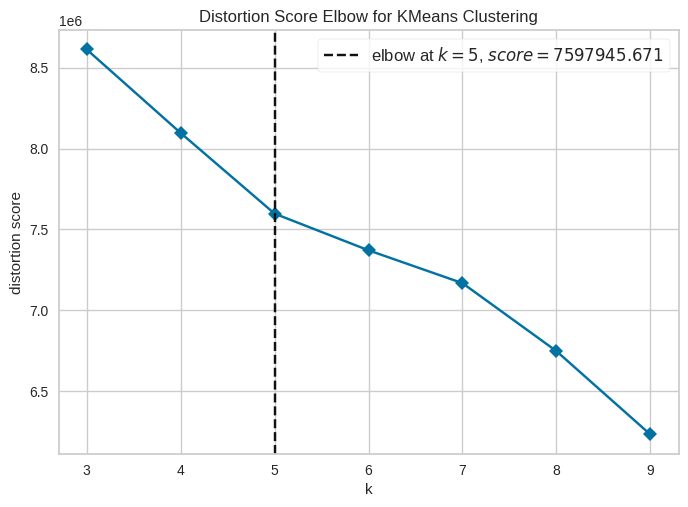

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

k = 0 
kmeans = KMeans(n_clusters=k, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(3,10), timings=False)
visualizer.fit(scaled_df)
visualizer.show()

In [ ]:
# from sklearn.metrics import silhouette_score, silhouette_samples

# silhouette_avg = silhouette_score(scaled_df, kmeans.labels_)
# print(silhouette_avg)

In [ ]:
# for k in range(4, 8):
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(df)
#     silhouette_avg = silhouette_score(scaled_df, kmeans.labels_)
#     print(f'cluster : {k} // silhouette index {silhouette_avg}')

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
results = kmeans.fit(scaled_df)

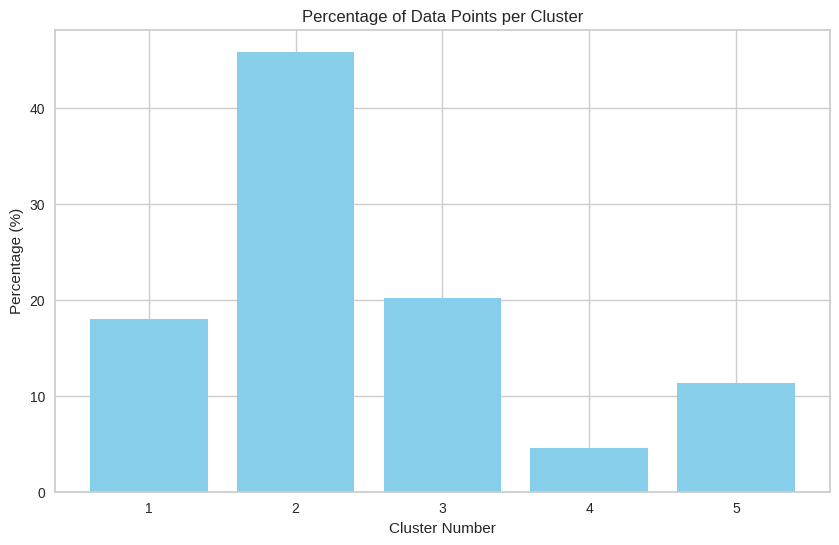

In [35]:
# Extracting labels from the model results
labels = results.labels_

# Counting occurrences of each cluster label
counts = np.bincount(labels)

# Calculating the percentage of each cluster
total_counts = np.sum(counts)
percentages = (counts / total_counts) * 100

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(percentages) + 1), percentages, color='skyblue')
plt.xlabel('Cluster Number')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Data Points per Cluster')
plt.xticks(range(1, len(percentages) + 1))
plt.show()

In [ ]:
우리카드 데이터를 중분류 컬럼, 성별, 사용량을 이용해서 클러스터링 진행한 결과.
궁금한 점 : 

In [36]:
clu_dff['Cluster'] = results.labels_

In [37]:
clu_dff

,AGE,SEX_CD,TOT_USE_AM,CRDSL_USE_AM,CNF_USE_AM,식료품·비주류음료,의류·신발,주거·수도·광열,보건,교통,오락·문화,교육,음식·숙박,기타,Cluster
SEQ,,,,,,,,,,,,,,,
00011N2I1MX4X9NQ16C0,55.000,1.0,205.714286,205.714286,0.0,0.00,0.00,0.00,0.000000,5.714286,0.000000,0.0,32.857143,0.000000,1
0003UZ715F1AVTCFVTLJ,34.375,1.0,705.000000,532.500000,167.5,11.25,0.00,11.25,87.500000,0.000000,2.500000,105.0,37.500000,0.000000,0
000C4EHXNK4O3VQRPMG3,65.000,1.0,25.000000,5.000000,20.0,0.00,0.00,0.00,5.000000,0.000000,0.000000,0.0,10.000000,0.000000,1
000FQ6EU9C0VJG9ECRUV,65.000,0.0,236.250000,236.250000,0.0,0.00,0.00,72.50,0.000000,0.000000,143.750000,0.0,3.750000,0.000000,2
000GG44JCBLXOD3Q87J1,70.000,1.0,128.333333,128.333333,0.0,0.00,0.00,0.00,46.666667,0.000000,21.666667,0.0,1.666667,8.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZHCT6AWPRO8PVIY2ES,45.000,0.0,947.500000,941.250000,0.0,1.25,1.25,12.50,46.250000,61.250000,146.250000,0.0,52.500000,0.000000,3
ZZZJS8E5I9X9P42V1WQ6,65.000,0.0,786.250000,786.250000,0.0,80.00,11.25,18.75,41.250000,91.250000,52.500000,0.0,55.000000,15.000000,3
ZZZSRQZX590MEOQ9R4Z2,55.000,0.0,1421.250000,283.750000,782.5,38.75,5.00,93.75,80.000000,82.500000,90.000000,0.0,57.500000,0.000000,4


In [38]:
aa = clu_dff.groupby('Cluster').agg({
    # 'AGE':'sum', 
    # 'SEX_CD':'sum', 
     # 'TOT_USE_AM':'mean', 
     # 'CRDSL_USE_AM':'mean', 
     # 'CNF_USE_AM':'mean',
    '식료품·비주류음료':'sum', 
    '의류·신발':'sum', 
    '주거·수도·광열':'sum', 
    '보건':'sum', 
    '교통':'sum', 
    '오락·문화':'sum', 
    '교육':'sum', 
    '음식·숙박':'sum', 
    '기타':'sum'
})

In [39]:
aa

,식료품·비주류음료,의류·신발,주거·수도·광열,보건,교통,오락·문화,교육,음식·숙박,기타
Cluster,,,,,,,,,
0,1.933214e+06,707469.369048,6.106018e+06,6.688210e+06,3.292248e+06,1.514790e+06,2.011902e+06,4.744681e+06,466303.333333
1,1.035659e+06,465402.785714,3.810692e+06,4.151206e+06,1.447507e+06,7.863280e+05,2.834344e+06,3.977326e+06,314654.011905
2,4.908910e+05,148505.511905,2.073216e+06,1.999294e+06,1.600397e+06,5.937935e+05,6.876826e+05,2.481541e+06,128286.083333
3,1.529278e+06,587784.095238,3.240617e+06,2.156584e+06,2.631930e+06,1.802274e+06,1.644638e+06,1.451736e+06,370337.940476
4,1.368437e+06,506344.619048,1.584863e+06,2.716296e+06,1.761901e+06,1.267951e+06,1.220739e+06,3.853009e+06,156166.880952


In [40]:
# 회원등급 별 각 항목 비율
aa.div(aa.sum(axis=1), axis=0)

,식료품·비주류음료,의류·신발,주거·수도·광열,보건,교통,오락·문화,교육,음식·숙박,기타
Cluster,,,,,,,,,
0,0.070389,0.025759,0.222321,0.243519,0.119871,0.055154,0.073254,0.172755,0.016978
1,0.055021,0.024725,0.202447,0.220538,0.076901,0.041775,0.150578,0.211300,0.016716
2,0.048110,0.014554,0.203185,0.195940,0.156846,0.058194,0.067396,0.243202,0.012573
3,0.099206,0.038130,0.210222,0.139900,0.170736,0.116916,0.106689,0.094176,0.024024
4,0.094795,0.035076,0.109788,0.188165,0.122052,0.087834,0.084564,0.266908,0.010818


In [41]:
#각 항목별 회원등급 비율
aa.div(aa.sum(axis=0), axis=1)

,식료품·비주류음료,의류·신발,주거·수도·광열,보건,교통,오락·문화,교육,음식·숙박,기타
Cluster,,,,,,,,,
0,0.304085,0.292887,0.363120,0.377618,0.306713,0.253940,0.239532,0.287412,0.324781
1,0.162904,0.192673,0.226619,0.234378,0.134853,0.131821,0.337450,0.240929,0.219157
2,0.077215,0.061480,0.123293,0.112881,0.149096,0.099544,0.081874,0.150321,0.089351
3,0.240548,0.243338,0.192717,0.121761,0.245196,0.302135,0.195806,0.087940,0.257941
4,0.215248,0.209623,0.094251,0.153363,0.164142,0.212560,0.145338,0.233398,0.108770


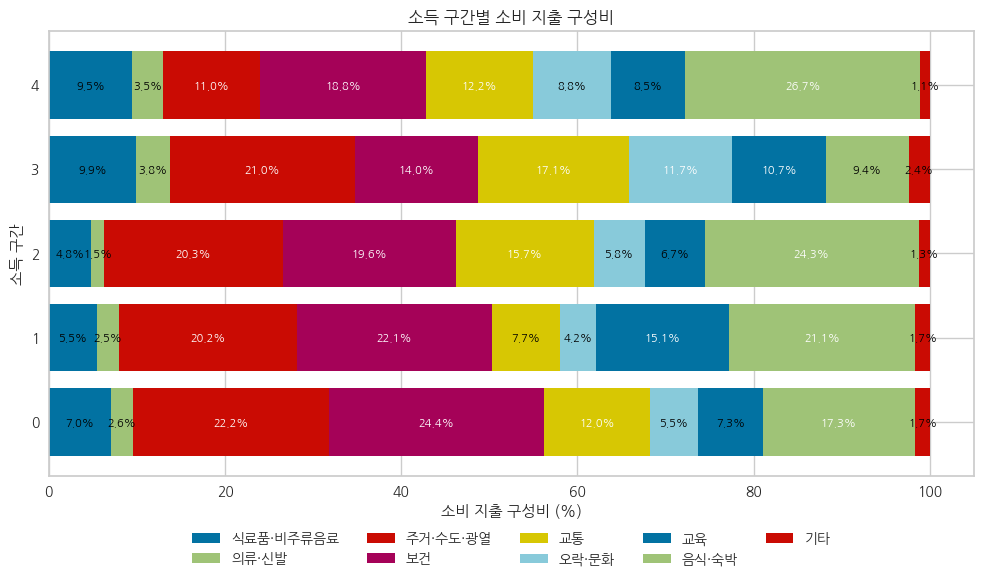

In [42]:
# 등급별 항목 비율
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 각 열의 값들을 그 열의 합으로 나눈 비율 DataFrame 사용
normalized_df = aa.div(aa.sum(axis=1), axis=0) * 100  # 비율을 퍼센트로 변환
normalized_df = normalized_df.reset_index(drop=True)

# 막대 차트 그리기
fig, ax = plt.subplots(figsize=(10, 6))
categories = normalized_df.columns
bar_width = 0.8


# 각 카테고리에 대한 누적 막대 생성
bottom = np.zeros(len(normalized_df))
for i, category in enumerate(categories):
    ax.barh(normalized_df.index, normalized_df[category], left=bottom, label=category)
    for j, value in enumerate(normalized_df[category]):
        # 각 항목 비율 텍스트 추가 (소수점 첫째 자리까지 표시)
        ax.text(bottom[j] + value / 2, normalized_df.index[j], f'{value:.1f}%', 
                ha='center', va='center', fontsize=8, color='black' if value < 10 else 'white')
    bottom += normalized_df[category]
    
# 레이블 설정 및 스타일링
ax.set_xlabel("소비 지출 구성비 (%)")
ax.set_ylabel("소득 구간")
ax.set_title("소득 구간별 소비 지출 구성비")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5)

plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 새로운 왼쪽 그래프 데이터
data_new_left = {
    '식료품·비주류음료': [9.5, 9.9, 4.8, 5.5, 7.0],
    # '의류·신발': [3.5, 3.8, 1.5, 2.5, 2.6],
    '주거·수도·광열': [11.0, 21.0, 20.3, 20.2, 22.2],
    '보건': [18.8, 14.0, 19.6, 22.1, 24.4],
    '교통': [12.2, 17.1, 15.7, 7.7, 12.0],
    # '오락·문화': [8.8, 11.7, 5.8, 4.2, 5.5],
    '교육': [8.5, 10.7, 6.7, 15.1, 7.3],
    # '음식·숙박': [26.7, 9.4, 24.3, 21.1, 17.3]
}

# 기존 오른쪽 그래프 데이터 (여기에 맞는 데이터를 넣어야 합니다.)
data_right = {
    '식료품·비주류음료': [20.6, 16.4, 13.8, 13.1, 11.5],
    '의류·신발': [3.9, 4.8, 5.6, 5.2, 6.0],
    '주거·수도·광열': [19.1, 17.0, 13.0, 10.1, 9.4],
    '보건': [13.4, 9.6, 8.2, 7.8, 7.5],
    '교통': [7.4, 9.4, 12.2, 13.6, 15.2],
    '오락·문화': [5.6, 6.2, 7.8, 7.4, 8.4],
    '교육': [1.0, 2.9, 4.2, 8.0, 8.5],
    '음식·숙박': [12.5, 15.7, 16.4, 16.2, 15.8]
}

df_new_left = pd.DataFrame(data_new_left)
df_right = pd.DataFrame(data_right)

# 코사인 유사도 계산
similarities = cosine_similarity(df_new_left, df_right)
max_indices = np.argmax(similarities, axis=1)

# 매칭 결과에 대한 인덱스를 사용해 소득 분위 매핑
income_quintiles = ['1분위', '2분위', '3분위', '4분위', '5분위']
mapped_quintiles = [income_quintiles[idx] for idx in max_indices]

# 결과 출력
for i, quintile in enumerate(mapped_quintiles):
    print(f'새 왼쪽 그래프 데이터 포인트 {i+1}는 오른쪽 그래프 {quintile}과 가장 유사합니다.')


새 왼쪽 그래프 데이터 포인트 1는 오른쪽 그래프 4분위과 가장 유사합니다.
새 왼쪽 그래프 데이터 포인트 2는 오른쪽 그래프 3분위과 가장 유사합니다.
새 왼쪽 그래프 데이터 포인트 3는 오른쪽 그래프 3분위과 가장 유사합니다.
새 왼쪽 그래프 데이터 포인트 4는 오른쪽 그래프 4분위과 가장 유사합니다.
새 왼쪽 그래프 데이터 포인트 5는 오른쪽 그래프 2분위과 가장 유사합니다.


In [ ]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import numpy as np
from time import time

# CUDA 커널 정의
cuda_kmeans_kernel = """
__global__ void calculate_distances(float *data, float *centroids, int *assignments,
                                  float *distances, int n_samples, int n_features, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        float min_dist = 1e10;
        int best_cluster = 0;

        for (int c = 0; c < n_clusters; c++) {
            float dist = 0.0f;

            for (int f = 0; f < n_features; f++) {
                float diff = data[idx * n_features + f] - centroids[c * n_features + f];
                dist += diff * diff;
            }

            distances[idx * n_clusters + c] = dist;
            if (dist < min_dist) {
                min_dist = dist;
                best_cluster = c;
            }
        }

        assignments[idx] = best_cluster;
    }
}

__global__ void calculate_inertia(float *distances, int *assignments,
                                float *inertia, int n_samples, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int cluster = assignments[idx];
        atomicAdd(inertia, distances[idx * n_clusters + cluster]);
    }
}

__global__ void update_centroids(float *data, int *assignments, float *new_centroids,
                               int *cluster_sizes, int n_samples, int n_features, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int cluster = assignments[idx];
        atomicAdd(&cluster_sizes[cluster], 1);

        for (int f = 0; f < n_features; f++) {
            atomicAdd(&new_centroids[cluster * n_features + f],
                     data[idx * n_features + f]);
        }
    }
}

__global__ void calculate_silhouette(float *data, int *labels, float *a_scores,
                                   float *b_scores, int n_samples, int n_features,
                                   int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        int my_cluster = labels[idx];
        float a_sum = 0.0f;
        int a_count = 0;
        float min_b = 1e10f;

        // a(i) 계산: 같은 클러스터 내 평균 거리
        for (int j = 0; j < n_samples; j++) {
            if (j != idx && labels[j] == my_cluster) {
                float dist = 0.0f;
                for (int f = 0; f < n_features; f++) {
                    float diff = data[idx * n_features + f] - data[j * n_features + f];
                    dist += diff * diff;
                }
                a_sum += sqrt(dist);
                a_count++;
            }
        }

        // a_scores 계산
        if (a_count > 0) {
            a_scores[idx] = a_sum / a_count;
        } else {
            a_scores[idx] = 0.0f;
        }

        // b(i) 계산: 다른 클러스터와의 최소 평균 거리
        for (int c = 0; c < n_clusters; c++) {
            if (c != my_cluster) {
                float b_sum = 0.0f;
                int b_count = 0;

                for (int j = 0; j < n_samples; j++) {
                    if (labels[j] == c) {
                        float dist = 0.0f;
                        for (int f = 0; f < n_features; f++) {
                            float diff = data[idx * n_features + f] - data[j * n_features + f];
                            dist += diff * diff;
                        }
                        b_sum += sqrt(dist);
                        b_count++;
                    }
                }

                if (b_count > 0) {
                    float avg_b = b_sum / b_count;
                    min_b = min(min_b, avg_b);
                }
            }
        }

        b_scores[idx] = min_b;
    }
}
"""

class GPUKMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

        # CUDA 커널 컴파일
        self.mod = SourceModule(cuda_kmeans_kernel)
        self.calculate_distances_kernel = self.mod.get_function("calculate_distances")
        self.calculate_inertia_kernel = self.mod.get_function("calculate_inertia")
        self.update_centroids_kernel = self.mod.get_function("update_centroids")
        self.calculate_silhouette_kernel = self.mod.get_function("calculate_silhouette")

    def fit(self, X):
        start_time = time()
        self.n_samples, self.n_features = X.shape
        X = X.astype(np.float32)

        # 초기 중심점 무작위 선택
        centroid_indices = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centroids = X[centroid_indices].astype(np.float32)

        # GPU 메모리 할당
        self.data_gpu = gpuarray.to_gpu(X)
        self.centroids_gpu = gpuarray.to_gpu(self.centroids)
        self.assignments_gpu = gpuarray.zeros(self.n_samples, dtype=np.int32)
        self.distances_gpu = gpuarray.zeros((self.n_samples, self.n_clusters), dtype=np.float32)

        # 블록 크기 설정
        self.block_size = 256
        self.grid_size = (self.n_samples + self.block_size - 1) // self.block_size

        # K-means 반복
        for iteration in range(self.max_iter):
            old_centroids = self.centroids.copy()

            # 거리 계산 및 할당
            self.calculate_distances_kernel(
                self.data_gpu, self.centroids_gpu, self.assignments_gpu,
                self.distances_gpu,
                np.int32(self.n_samples), np.int32(self.n_features),
                np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )

            # 새로운 중심점 계산
            new_centroids = np.zeros((self.n_clusters, self.n_features), dtype=np.float32)
            cluster_sizes = np.zeros(self.n_clusters, dtype=np.int32)

            new_centroids_gpu = gpuarray.to_gpu(new_centroids)
            cluster_sizes_gpu = gpuarray.to_gpu(cluster_sizes)

            self.update_centroids_kernel(
                self.data_gpu, self.assignments_gpu, new_centroids_gpu,
                cluster_sizes_gpu, np.int32(self.n_samples),
                np.int32(self.n_features), np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )

            # CPU로 데이터 복사
            new_centroids = new_centroids_gpu.get()
            cluster_sizes = cluster_sizes_gpu.get()

            # 중심점 업데이트
            for i in range(self.n_clusters):
                if cluster_sizes[i] > 0:
                    new_centroids[i] /= cluster_sizes[i]

            self.centroids = new_centroids
            self.centroids_gpu = gpuarray.to_gpu(self.centroids)

            # Inertia 계산
            inertia_gpu = gpuarray.zeros(1, dtype=np.float32)
            self.calculate_inertia_kernel(
                self.distances_gpu, self.assignments_gpu, inertia_gpu,
                np.int32(self.n_samples), np.int32(self.n_clusters),
                block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
            )
            self.inertia_ = float(inertia_gpu.get()[0])  # DeprecationWarning 해결

            # 수렴 확인
            if np.all(np.abs(old_centroids - self.centroids) < self.tol):
                break

        self.labels_ = self.assignments_gpu.get()
        self.cluster_centers_ = self.centroids
        self.processing_time_ = time() - start_time

        return self

    def calculate_silhouette(self, X):
        """
        GPU로 Silhouette score 계산
        """
        n_samples = X.shape[0]

        # GPU 메모리 할당
        a_scores_gpu = gpuarray.zeros(n_samples, dtype=np.float32)
        b_scores_gpu = gpuarray.zeros(n_samples, dtype=np.float32)

        # Silhouette 계산
        self.calculate_silhouette_kernel(
            self.data_gpu, self.assignments_gpu,
            a_scores_gpu, b_scores_gpu,
            np.int32(n_samples), np.int32(self.n_features),
            np.int32(self.n_clusters),
            block=(self.block_size, 1, 1), grid=(self.grid_size, 1)
        )

        # 결과 가져오기
        a_scores = a_scores_gpu.get()
        b_scores = b_scores_gpu.get()

        # Silhouette score 계산
        s_scores = (b_scores - a_scores) / np.maximum(a_scores, b_scores)
        return np.mean(s_scores)

def run_clustering_analysis(data, k_range=(3,10)):
    """
    여러 k값에 대해 클러스터링 수행
    """
    results = {}

    for k in range(k_range[0], k_range[1] + 1):
        print(f"\nRunning clustering for k={k}")
        kmeans = GPUKMeans(n_clusters=k)
        kmeans.fit(data)

        # Silhouette score 계산
        silhouette = kmeans.calculate_silhouette(data)

        # 클러스터별 분석
        cluster_analysis = {}
        for i in range(k):
            mask = kmeans.labels_ == i
            cluster_analysis[f'Cluster {i}'] = {
                'size': np.sum(mask),
                'center': kmeans.cluster_centers_[i]
            }

        results[k] = {
            'labels': kmeans.labels_,
            'centroids': kmeans.cluster_centers_,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette,
            'processing_time': kmeans.processing_time_,
            'cluster_analysis': cluster_analysis
        }

        print(f"Processing time: {kmeans.processing_time_:.2f} seconds")
        print(f"Inertia: {kmeans.inertia_:.2f}")
        print(f"Silhouette score: {silhouette:.3f}")

    return results


In [ ]:
def visualize_clustering_results(results, data):
    """
    GPU K-means 클러스터링 결과 시각화
    """
    k_values = list(results.keys())

    # 결과 메트릭 수집
    inertias = [results[k]['inertia'] for k in k_values]
    processing_times = [results[k]['processing_time'] for k in k_values]

    # 1. 주요 메트릭 시각화 (2x2 서브플롯)
    fig = plt.figure(figsize=(20, 15))

    # 1-1. Elbow curve
    plt.subplot(221)
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve')
    plt.grid(True)

    # 1-2. 처리 시간
    plt.subplot(222)
    plt.plot(k_values, processing_times, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Processing Time (seconds)')
    plt.title('Processing Time by Number of Clusters')
    plt.grid(True)

    # 1-3. 클러스터 크기 분포
    plt.subplot(223)
    cluster_sizes_data = []
    cluster_labels = []
    for k in k_values:
        sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
        cluster_sizes_data.extend(sizes)
        cluster_labels.extend([f'k={k}'] * len(sizes))

    sns.boxplot(x=cluster_labels, y=cluster_sizes_data)
    plt.xticks(rotation=45)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Cluster Size')
    plt.title('Distribution of Cluster Sizes')

    # 1-4. 클러스터 간 거리 분포
    plt.subplot(224)
    for k in k_values:
        centroids = results[k]['centroids']
        distances = []
        for i in range(len(centroids)):
            for j in range(i+1, len(centroids)):
                dist = np.linalg.norm(centroids[i] - centroids[j])
                distances.append(dist)
        plt.scatter([k]*len(distances), distances, alpha=0.5)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inter-cluster Distance')
    plt.title('Distribution of Inter-cluster Distances')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 2. 분석 결과 출력
    print("\n=== Clustering Analysis Results ===")

    # Elbow method - 2차 미분의 최대값 지점 찾기
    k_array = np.array(k_values)
    inertia_array = np.array(inertias)
    second_derivative = np.diff(np.diff(inertia_array))
    elbow_idx = np.argmax(np.abs(second_derivative)) + 1
    best_k_elbow = k_values[elbow_idx]

    print("\nOptimal k Analysis:")
    print(f"- By Elbow method: k={best_k_elbow}")

    print("\nDetailed Metrics for each k:")
    for k in k_values:
        print(f"\nk={k}:")
        print(f"  Inertia: {results[k]['inertia']:.0f}")
        print(f"  Processing Time: {results[k]['processing_time']:.2f} seconds")
        sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
        print(f"  Cluster Sizes: {sizes}")

    # 3. 최적 k에 대한 상세 분석
    best_k = best_k_elbow
    print(f"\n=== Detailed Analysis for Best k={best_k} ===")

    # 클러스터별 특성
    cluster_analysis = results[best_k]['cluster_analysis']
    for cluster, details in cluster_analysis.items():
        print(f"\n{cluster}:")
        print(f"Size: {details['size']} samples")
        print(f"Center features (top 5 absolute values):")
        center = details['center']
        top_features = np.argsort(np.abs(center))[-5:]
        for idx in top_features:
            print(f"Feature {idx}: {center[idx]:.3f}")

def plot_cluster_details(results, k, data_columns):
    """
    특정 k값에 대한 클러스터 상세 분석
    """
    plt.figure(figsize=(15, 10))

    # 중심점 히트맵
    centers = results[k]['centroids']
    sns.heatmap(centers, cmap='RdBu_r', center=0,
                xticklabels=data_columns,
                yticklabels=[f'Cluster {i}' for i in range(k)])
    plt.title(f'Cluster Centers Heatmap (k={k})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 클러스터별 크기 분포
    sizes = [analysis['size'] for analysis in results[k]['cluster_analysis'].values()]
    plt.figure(figsize=(10, 5))
    plt.bar(range(k), sizes)
    plt.title(f'Cluster Sizes (k={k})')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# 3. GPU 클러스터링 실행
# k=3부터 10까지 분석
results = run_clustering_analysis(scaled_data.values, k_range=(3, 10))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 4. 기본 시각화
visualize_clustering_results(results, scaled_data)

In [ ]:
# 5. 특정 k값에 대한 상세 분석
plot_cluster_details(results, k=6, data_columns=scaled_data.columns)

In [ ]:
##할일
# lifestyle채워지면 나머지 age도 채울 수 있을 것 같기도
#변동량넣기 => 카드사용액 변동량
#클러스터링